Quick look at pre-release v3.1 results

Runs in here:
* Previous baselines
    * `retro_baseline_v2.0_10yrs.db` (like v1.x runs)
    * `baseline_v2.0_10yrs.db`
    * `baseline_v2.1_10yrs.db`
    * `baseline_v2.2_10yrs.db`
    * `baseline_v3.0_10yrs.db`
* `starter_v3.1_10yrs.db`
    * update to the footprint to include small Euclid swath
    * update survey start time
    * uzy filter swapping rather than just uz
    * updated to newer cloud database
    * telescope now parks with r-filter in. Should be no filter change time added when coming out of park.
    * updated long gaps survey to only attempt log gaps if early pair was sucessful
    * blobs no longer have az and radius limits (mostly a change for visulization)
    

Runs below are like starter_v3.1 except how noted.

* `m2_starter`
    * same as `starter`, but run on apple silicon. Mostly for checking cross-platform repeatability
* `filtlers_uy`
    * swaps y in for u in bright time
* `filters_uz`
    * swaps z in for u in bright time (like previous baselines)
* `noroll`
    * no rolling candence. Requested by DESC to look at uniformity at data releases
* `old_mjd0_uz`
    * rolling back the survey start date, swapping only u and z filters
* `old_mjd0`
    * rolling back survey start date, swapping u with z & y
* `threeroll`
    * only three seasons of rolling. Looking at final survey uniformity
*  `weather_cloudso...`
    * Varying the start year of our cloud database. Provides a handy way to look at the precision of metric values and the limits to which we can expect to optimize the survey
* `no_plane`, `light_plane`, `heavy_plane`
    * Varying the amount of observing in the dusty plane. Mostly so we can check self calibration schemes. 
* `more_u_utw`
    * Vary the weight on getting u-band templates. Noted starter wasn't doing a great job closing the sky for calibration in year 1



In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:
# download summary file if needed
if not os.path.isfile('summary.h5'):
    import requests
    url = 'https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.1/maf/summary.h5'
    r = requests.get(url)
    open('summary.h5', 'wb').write(r.content)

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(116, 51193)

In [4]:
#data_loaded['Total detected -6.4 LVDwarfs gi UserPointsSlicer']

In [5]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'quad' in col and 'PHA' in col]

In [37]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [38]:
data

FF u      FF g      FF r      FF i   
baseline_v2.0_10yrs          0.955776  0.981594  0.994441  0.997035  \
baseline_v2.1_10yrs          0.948661  0.984188  0.996912  0.999012   
baseline_v2.2_10yrs          0.871233  0.914268  0.993947  0.998023   
baseline_v3.0_10yrs          0.813058  0.901174  0.993823  0.999135   
ddf_split_v3.1_10yrs         0.719587  0.899815  0.982335  0.998641   
...                               ...       ...       ...       ...   
weather_cloudso35v3.1_10yrs  0.667550  0.778876  0.963805  0.996788   
weather_cloudso36v3.1_10yrs  0.618304  0.765287  0.955034  0.993082   
weather_cloudso4v3.1_10yrs   0.711635  0.859914  0.986535  0.998765   
weather_cloudso6v3.1_10yrs   0.720145  0.872514  0.984682  0.997529   
weather_cloudso8v3.1_10yrs   0.671038  0.832983  0.971958  0.996788   

                             parallax best 18k  proper motion best 18k   
baseline_v2.0_10yrs                   0.791058                0.184088  \
baseline_v2.1_10yrs                   0.806910                0.188258   
baseline_v2.2_10yrs                   0.792958                0.186345   
baseline_v3.0_10yrs                   0.792666                0.185683   
ddf_split_v3.1_10yrs                  0.805419                0.188945   
...                                        ...                     ...   
weather_cloudso35v3.1_10yrs           0.780742                0.182876   
weather_cloudso36v3.1_10yrs           0.777124                0.184815   
weather_cloudso4v3.1_10yrs            0.773331                0.184599   
weather_cloudso6v3.1_10yrs            0.764497                0.180800   
weather_cloudso8v3.1_10yrs            0.777786                0.185520   

                             20-30d microlensing\ndetection   
baseline_v2.0_10yrs                                  0.3116  \
baseline_v2.1_10yrs                                  0.3111   
baseline_v2.2_10yrs                                  0.3212   
baseline_v3.0_10yrs                                  0.3239   
ddf_split_v3.1_10yrs                                 0.3305   
...                                                     ...   
weather_cloudso35v3.1_10yrs                          0.3273   
weather_cloudso36v3.1_10yrs                          0.3287   
weather_cloudso4v3.1_10yrs                           0.3370   
weather_cloudso6v3.1_10yrs                           0.3360   
weather_cloudso8v3.1_10yrs                           0.3244   

                             60-90d microlensing\ndetection  fO N vis   
baseline_v2.0_10yrs                                  0.4284     839.0  \
baseline_v2.1_10yrs                                  0.4312     838.0   
baseline_v2.2_10yrs                                  0.4462     830.0   
baseline_v3.0_10yrs                                  0.4559     795.0   
ddf_split_v3.1_10yrs                                 0.4672     788.0   
...                                                     ...       ...   
weather_cloudso35v3.1_10yrs                          0.4479     837.0   
weather_cloudso36v3.1_10yrs                          0.4454     831.0   
weather_cloudso4v3.1_10yrs                           0.4570     841.0   
weather_cloudso6v3.1_10yrs                           0.4586     866.0   
weather_cloudso8v3.1_10yrs                           0.4459     844.0   

                                    SNe, N  ...  KNe single model   
baseline_v2.0_10yrs           99302.532220  ...            4544.0  \
baseline_v2.1_10yrs           99294.339899  ...            4777.0   
baseline_v2.2_10yrs          112802.099640  ...            5215.0   
baseline_v3.0_10yrs          109475.798536  ...            5654.0   
ddf_split_v3.1_10yrs         119794.942728  ...            5311.0   
...                                    ...  ...               ...   
weather_cloudso35v3.1_10yrs  122586.874656  ...            5544.0   
weather_cloudso36v3.1_10yrs  120458.956707  ...            5468.0   
weather_cloudso4v3.1_10yrs   130239.

In [39]:
#data['KNe single model'] # data['KNe ZTF simple']

In [40]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [41]:
mag_data

g          i          r          u   
baseline_v2.0_10yrs          26.733479  26.218659  26.755971  25.818916  \
baseline_v2.1_10yrs          26.736248  26.252054  26.781543  25.751969   
baseline_v2.2_10yrs          26.753646  26.290929  26.835430  25.724699   
baseline_v3.0_10yrs          26.688123  26.264600  26.818287  25.668262   
ddf_split_v3.1_10yrs         26.692665  26.272189  26.809697  25.667079   
...                                ...        ...        ...        ...   
weather_cloudso35v3.1_10yrs  26.697583  26.289448  26.820743  25.674504   
weather_cloudso36v3.1_10yrs  26.699122  26.301709  26.822116  25.661365   
weather_cloudso4v3.1_10yrs   26.739079  26.325156  26.850194  25.710098   
weather_cloudso6v3.1_10yrs   26.746729  26.332379  26.860380  25.708482   
weather_cloudso8v3.1_10yrs   26.706248  26.315459  26.833249  25.675369   

                                     y          z  
baseline_v2.0_10yrs          24.762720  25.510379  
baseline_v2.1_10yrs          24.728145  25.486640  
baseline_v2.2_10yrs          24.782743  25.581317  
baseline_v3.0_10yrs          24.756955  25.524781  
ddf_split_v3.1_10yrs         24.762905  25.569103  
...                                ...        ...  
weather_cloudso35v3.1_10yrs  24.760152  25.573283  
weather_cloudso36v3.1_10yrs  24.755164  25.572835  
weather_cloudso4v3.1_10yrs   24.789720  25.597164  
weather_cloudso6v3.1_10yrs   24.798368  25.600056  
weather_cloudso8v3.1_10yrs   24.777364  25.586627  

[116 rows x 6 columns]

In [42]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

N SN COSMOS  N SN ECDFS   N SN EDFS   
baseline_v2.0_10yrs            47.333916    5.217382         NaN  \
baseline_v2.1_10yrs            21.899369    2.592571         NaN   
baseline_v2.2_10yrs            13.647867    6.881372         NaN   
baseline_v3.0_10yrs           362.726856   72.383449   74.734786   
ddf_split_v3.1_10yrs          580.936525  455.187854  803.466338   
...                                  ...         ...         ...   
weather_cloudso35v3.1_10yrs   537.432980  115.785469  199.123051   
weather_cloudso36v3.1_10yrs   581.399410  132.496374  257.124797   
weather_cloudso4v3.1_10yrs    590.688902  271.483832  527.710173   
weather_cloudso6v3.1_10yrs    594.477290  240.758049  491.338582   
weather_cloudso8v3.1_10yrs    565.842455  179.512596  319.915459   

                             N SN ELAISS1  N SN XMM_LSS  zlim COSMOS   
baseline_v2.0_10yrs             81.438800     72.445437     0.596891  \
baseline_v2.1_10yrs             40.212476     32.838014     0.594427   
baseline_v2.2_10yrs              3.753806           NaN     0.514987   
baseline_v3.0_10yrs             37.378088     60.363667     0.594675   
ddf_split_v3.1_10yrs           393.295885    374.911756     0.545961   
...                                   ...           ...          ...   
weather_cloudso35v3.1_10yrs    241.181939    131.254708     0.577584   
weather_cloudso36v3.1_10yrs    247.127353    143.019505     0.563573   
weather_cloudso4v3.1_10yrs     305.310627    310.731382     0.573630   
weather_cloudso6v3.1_10yrs     331.385198    237.233429     0.573241   
weather_cloudso8v3.1_10yrs     246.100727    238.209351     0.574958   

                             zlim ECDFS  zlim EDFS  zlim ELAISS1  zlim XMM_LSS  
baseline_v2.0_10yrs            0.543027        NaN      0.593426      0.562289  
baseline_v2.1_10yrs            0.545216        NaN      0.594464      0.561932  
baseline_v2.2_10yrs            0.577431        NaN      0.600156           NaN  
baseline_v3.0_10yrs            0.575080   0.526724      0.546128      0.539335  
ddf_split_v3.1_10yrs           0.578368   0.514147      0.557940      0.543341  
...                                 ...        ...           ...           ...  
weather_cloudso35v3.1_10yrs    0.557749   0.502648      0.559124      0.532015  
weather_cloudso36v3.1_10yrs    0.567494   0.520775      0.556272      0.528580  
weather_cloudso4v3.1_10yrs     0.576830   0.523052      0.567219      0.551674  
weather_cloudso6v3.1_10yrs     0.577915   0.519142      0.569241      0.543935  
weather_cloudso8v3.1_10yrs     0.571748   0.513894      0.560384      0.557740  

[116 rows x 10 columns]

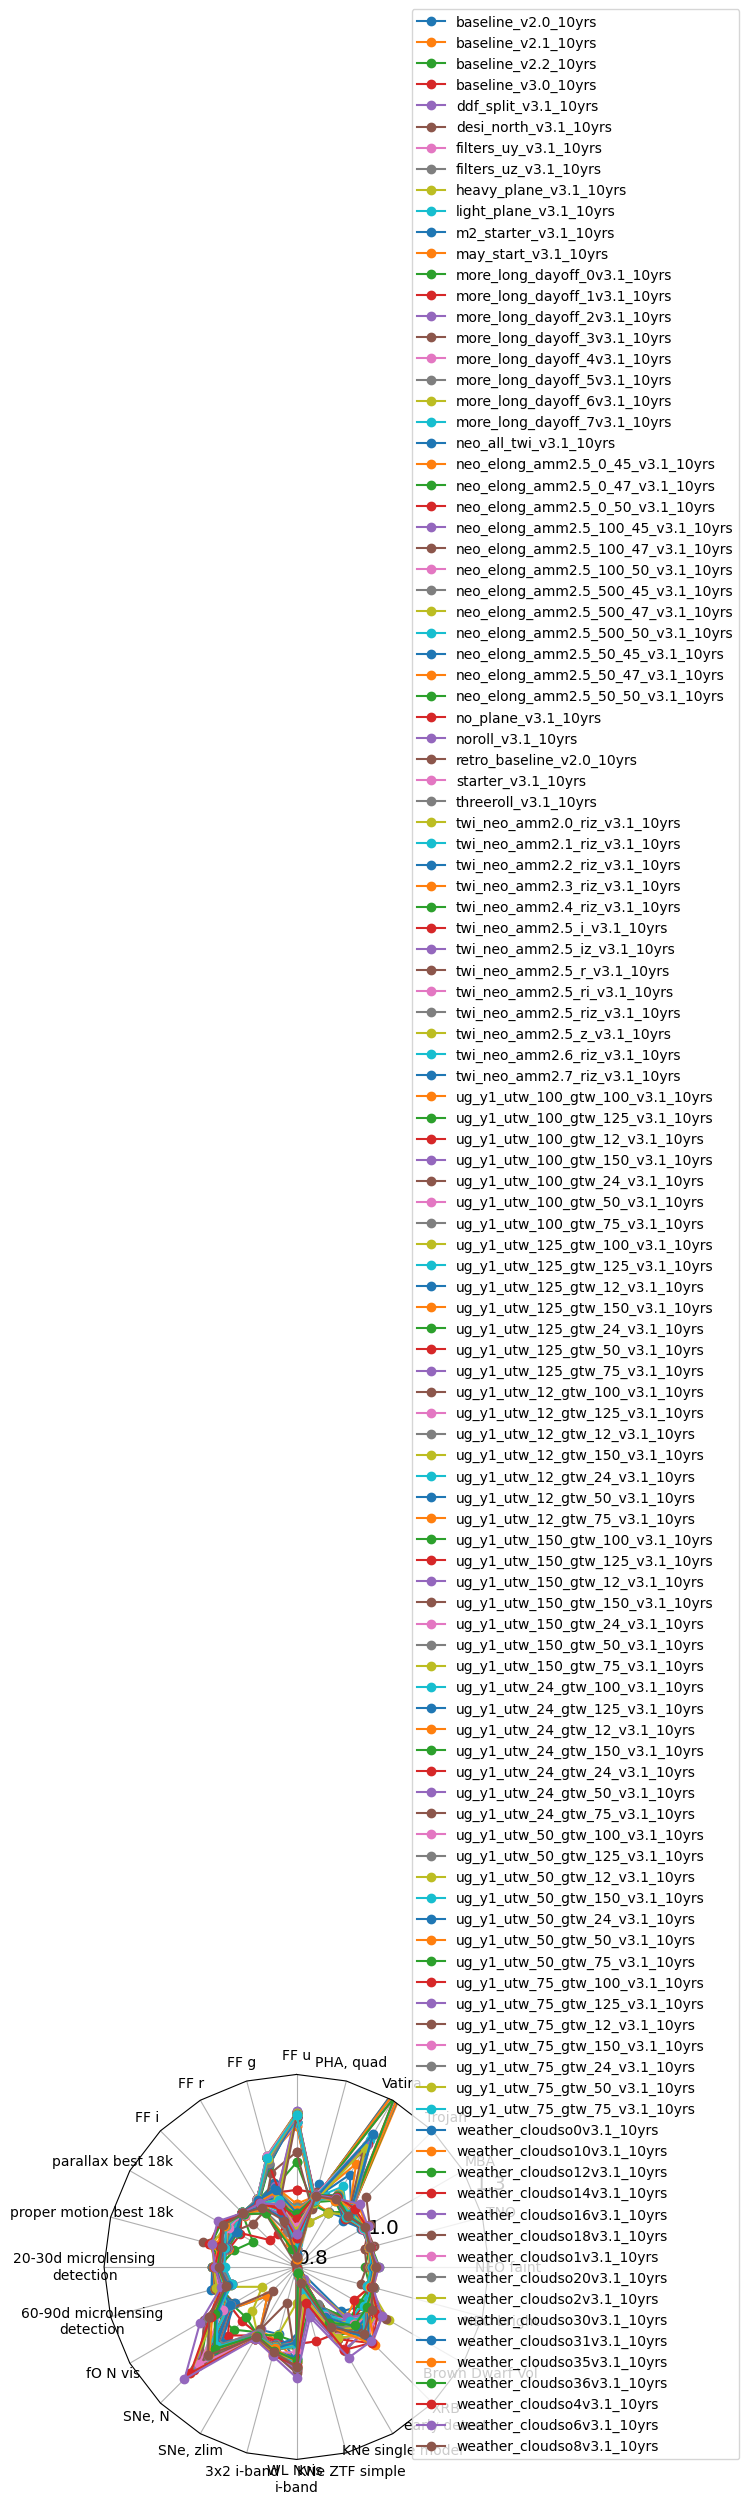

In [43]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

# DESI north strip

As expected, no big gains, lots of small minusus.

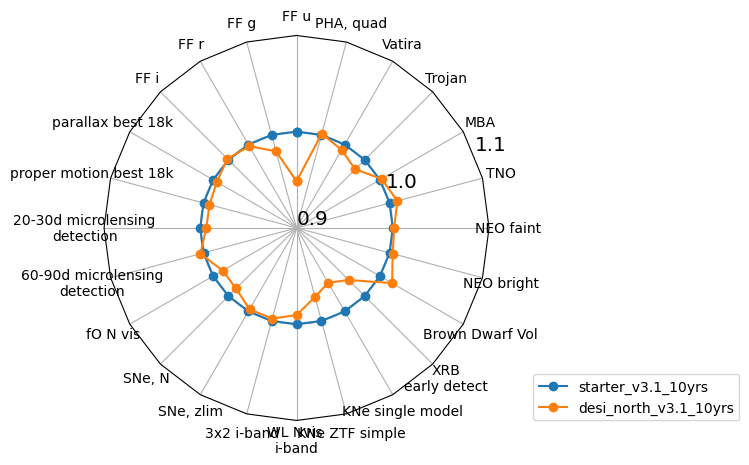

In [44]:
# Desi north
runs = ['starter_v3.1_10yrs', 'desi_north_v3.1_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Which filters to load

The KNe metrics seem to really prefer swapping u and z only. I'm not sure why this is. Also keep in mind this is a ~10% increase on a fraction that is very small. We are injecting 500k KNe events, and recovering ~5000. So this is gain of 1% to 1.1% of KNe events.

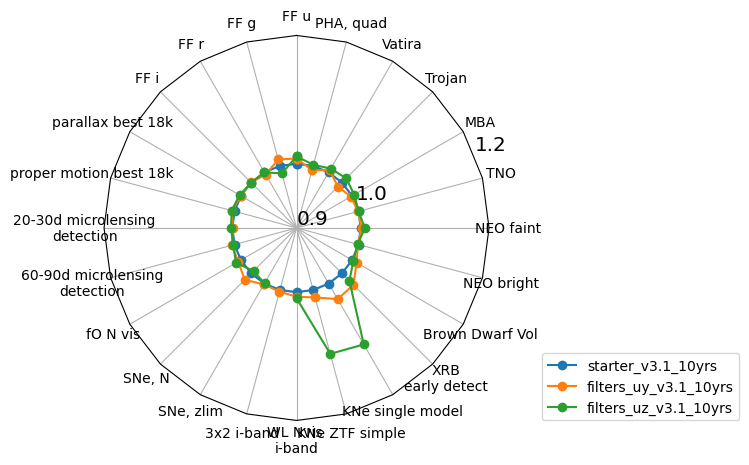

In [45]:
runs = ['starter_v3.1_10yrs'] + [run for run in data.index if 'filters' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

In [46]:
data.loc[runs]

FF u      FF g      FF r      FF i   
starter_v3.1_10yrs     0.764648  0.907350  0.994688  0.998271  \
filters_uy_v3.1_10yrs  0.770926  0.916862  0.990859  0.998765   
filters_uz_v3.1_10yrs  0.773438  0.896479  0.994812  0.997900   

                       parallax best 18k  proper motion best 18k   
starter_v3.1_10yrs              0.806804                0.187549  \
filters_uy_v3.1_10yrs           0.806616                0.186770   
filters_uz_v3.1_10yrs           0.804704                0.186679   

                       20-30d microlensing\ndetection   
starter_v3.1_10yrs                             0.3315  \
filters_uy_v3.1_10yrs                          0.3310   
filters_uz_v3.1_10yrs                          0.3336   

                       60-90d microlensing\ndetection  fO N vis   
starter_v3.1_10yrs                             0.4585     794.0  \
filters_uy_v3.1_10yrs                          0.4626     798.0   
filters_uz_v3.1_10yrs                          0.4607     801.0   

                              SNe, N  ...  KNe single model   
starter_v3.1_10yrs     120595.577833  ...            5366.0  \
filters_uy_v3.1_10yrs  122301.267710  ...            5516.0   
filters_uz_v3.1_10yrs  119966.934606  ...            5954.0   

                       XRB\nearly detect  Brown Dwarf Vol  NEO bright   
starter_v3.1_10yrs                1997.0    172220.399208      0.9300  \
filters_uy_v3.1_10yrs             2048.0    173618.644486      0.9290   
filters_uz_v3.1_10yrs             2030.0    172611.238755      0.9286   

                       NEO faint       TNO       MBA    Trojan  Vatira   
starter_v3.1_10yrs      0.640541  0.722337  0.930381  0.607340  0.0464  \
filters_uy_v3.1_10yrs   0.642106  0.721448  0.928304  0.598271  0.0504   
filters_uz_v3.1_10yrs   0.646980  0.722518  0.934123  0.616839  0.0531   

                       PHA, quad  
starter_v3.1_10yrs      0.877435  
filters_uy_v3.1_10yrs   0.871604  
filters_uz_v3.1_10yrs   0.879108  

[3 rows x 24 columns]

# How much to run long gaps

As exected, running long gaps every day has some pretty strong negative impacts across the board. Going up to every 3 days should be fine though.

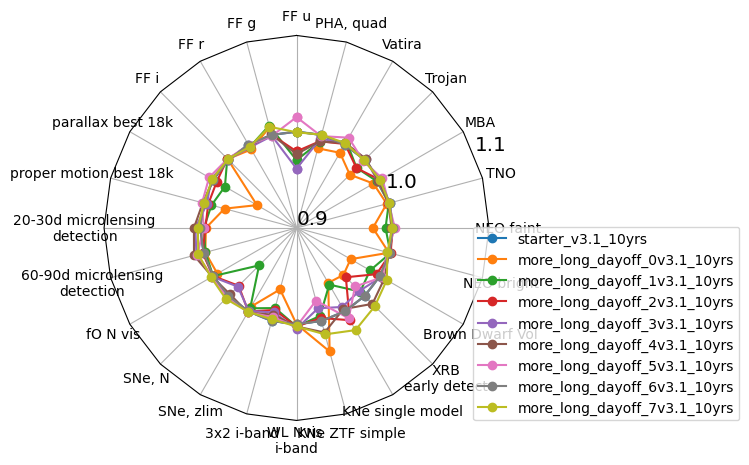

In [47]:
#  
runs = ['starter_v3.1_10yrs'] + [run for run in data.index if 'more_long' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [17]:
data.loc[runs]

parallax best 18k  proper motion best 18k   
starter_v3.1_10yrs                     0.806804                0.187549  \
more_long_dayoff_0v3.1_10yrs           0.851541                0.191877   
more_long_dayoff_1v3.1_10yrs           0.818305                0.189164   
more_long_dayoff_2v3.1_10yrs           0.810199                0.188485   
more_long_dayoff_3v3.1_10yrs           0.805049                0.188222   
more_long_dayoff_4v3.1_10yrs           0.806995                0.187391   
more_long_dayoff_5v3.1_10yrs           0.802867                0.187264   
more_long_dayoff_6v3.1_10yrs           0.806804                0.187549   
more_long_dayoff_7v3.1_10yrs           0.805795                0.187618   

                              20-30d microlensing\ndetection   
starter_v3.1_10yrs                                    0.3315  \
more_long_dayoff_0v3.1_10yrs                          0.3257   
more_long_dayoff_1v3.1_10yrs                          0.3278   
more_long_dayoff_2v3.1_10yrs                          0.3262   
more_long_dayoff_3v3.1_10yrs                          0.3366   
more_long_dayoff_4v3.1_10yrs                          0.3381   
more_long_dayoff_5v3.1_10yrs                          0.3280   
more_long_dayoff_6v3.1_10yrs                          0.3315   
more_long_dayoff_7v3.1_10yrs                          0.3340   

                              60-90d microlensing\ndetection  fO N vis   
starter_v3.1_10yrs                                    0.4585     794.0  \
more_long_dayoff_0v3.1_10yrs                          0.4566     790.0   
more_long_dayoff_1v3.1_10yrs                          0.4565     794.0   
more_long_dayoff_2v3.1_10yrs                          0.4595     794.0   
more_long_dayoff_3v3.1_10yrs                          0.4662     795.0   
more_long_dayoff_4v3.1_10yrs                          0.4688     795.0   
more_long_dayoff_5v3.1_10yrs                          0.4651     795.0   
more_long_dayoff_6v3.1_10yrs                          0.4585     794.0   
more_long_dayoff_7v3.1_10yrs                          0.4642     796.0   

                                     SNe, N  SNe, zlim  3x2 i-band   
starter_v3.1_10yrs            120595.577833   0.302535   39.394057  \
more_long_dayoff_0v3.1_10yrs  107889.014728   0.296820   38.058294   
more_long_dayoff_1v3.1_10yrs  115167.405652   0.298904   38.850002   
more_long_dayoff_2v3.1_10yrs  118787.323017   0.302826   38.928526   
more_long_dayoff_3v3.1_10yrs  118938.198454   0.301979   39.036939   
more_long_dayoff_4v3.1_10yrs  120308.378991   0.303920   39.131508   
more_long_dayoff_5v3.1_10yrs  120828.042177   0.303530   39.235669   
more_long_dayoff_6v3.1_10yrs  120595.577833   0.302535   39.394057   
more_long_dayoff_7v3.1_10yrs  121082.901812   0.303156   39.324359   

                              WL Nvis \ni-band  KNe ZTF simple   
starter_v3.1_10yrs                       421.0          3529.0  \
more_long_dayoff_0v3.1_10yrs             421.0          3645.0   
more_long_dayoff_1v3.1_10yrs             422.0          3510.0   
more_long_dayoff_2v3.1_10yrs             422.0          3518.0   
more_long_dayoff_3v3.1_10yrs             423.0          3481.0   
more_long_dayoff_4v3.1_10yrs             422.0          3573.0   
more_long_dayoff_5v3.1_10yrs             422.0          3452.0   
more_long_dayoff_6v3.1_10yrs             421.0          3529.0   
more_long_dayoff_7v3.1_10yrs             422.0          3580.0   

                              KNe single model  XRB\nearly detect   
starter_v3.1_10yrs                      5366.0             1997.0  \
more_long_dayoff_0v3.1_10yrs            5183.0             1935.0   
more_long_dayoff_1v3.1_10yrs            5194.0             1984.0   
more_long_dayoff_2v3.1_10yrs            5423.0             1942.0   
more_long_dayoff_3v3.1_10yrs            5338.0             1982.0   
more_long_dayoff_4v3.1_10yrs            5352.0             2020.0   
more_long_dayoff_5v3.1_10yrs            5411.0      

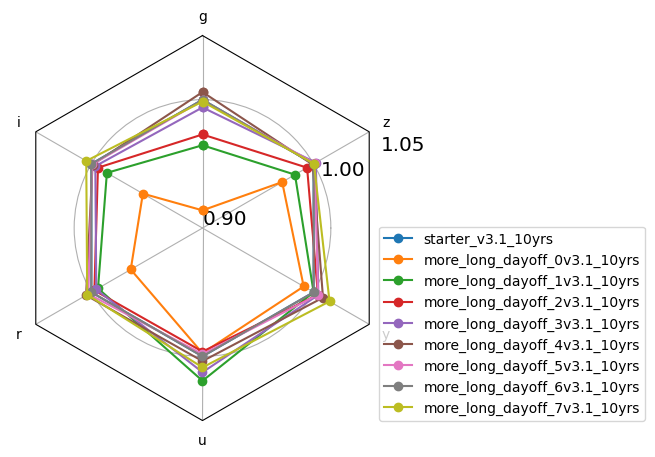

In [18]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

# How to set solar elongation limit for twilight Vatira

A lot of variation in these. Looks like have a solar elongation cut at 47 or 45 degrees and no minimum area requirement is the best. 

PHA quad detection has surprisingly little variation. We could also try varying the number of nights we run this.

These observations do look to be sometimes useful for microlensing and XRBs. Do we want to always run in when the Galactic plane is available? Do we think we can get the Vatiras out with all that background? 

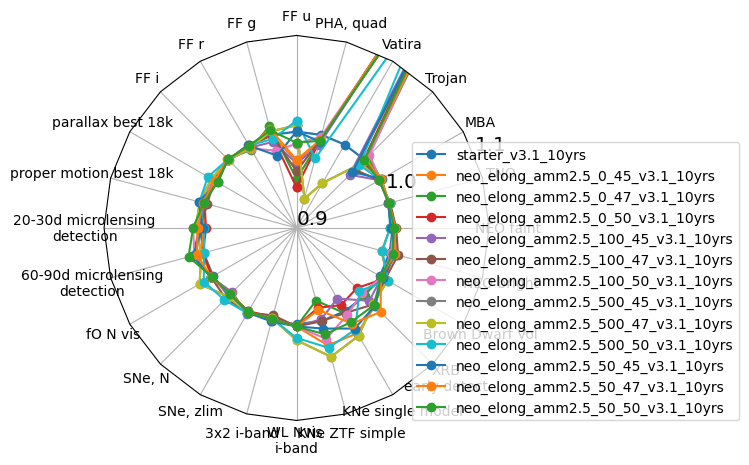

In [48]:
runs = ['starter_v3.1_10yrs'] + [run for run in data.index if 'neo_elon' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [20]:
data.loc[runs]

parallax best 18k  proper motion best 18k   
starter_v3.1_10yrs                           0.806804                0.187549  \
neo_elong_amm2.5_0_45_v3.1_10yrs             0.806368                0.187542   
neo_elong_amm2.5_0_47_v3.1_10yrs             0.805787                0.188035   
neo_elong_amm2.5_0_50_v3.1_10yrs             0.809557                0.187747   
neo_elong_amm2.5_100_45_v3.1_10yrs           0.806900                0.187567   
neo_elong_amm2.5_100_47_v3.1_10yrs           0.807660                0.188312   
neo_elong_amm2.5_100_50_v3.1_10yrs           0.805542                0.187552   
neo_elong_amm2.5_500_45_v3.1_10yrs           0.805113                0.186775   
neo_elong_amm2.5_500_47_v3.1_10yrs           0.805113                0.186775   
neo_elong_amm2.5_500_50_v3.1_10yrs           0.801775                0.186710   
neo_elong_amm2.5_50_45_v3.1_10yrs            0.811300                0.186574   
neo_elong_amm2.5_50_47_v3.1_10yrs            0.808471                0.187375   
neo_elong_amm2.5_50_50_v3.1_10yrs            0.811072                0.187580   

                                    20-30d microlensing\ndetection   
starter_v3.1_10yrs                                          0.3315  \
neo_elong_amm2.5_0_45_v3.1_10yrs                            0.3277   
neo_elong_amm2.5_0_47_v3.1_10yrs                            0.3307   
neo_elong_amm2.5_0_50_v3.1_10yrs                            0.3256   
neo_elong_amm2.5_100_45_v3.1_10yrs                          0.3325   
neo_elong_amm2.5_100_47_v3.1_10yrs                          0.3319   
neo_elong_amm2.5_100_50_v3.1_10yrs                          0.3390   
neo_elong_amm2.5_500_45_v3.1_10yrs                          0.3361   
neo_elong_amm2.5_500_47_v3.1_10yrs                          0.3361   
neo_elong_amm2.5_500_50_v3.1_10yrs                          0.3277   
neo_elong_amm2.5_50_45_v3.1_10yrs                           0.3290   
neo_elong_amm2.5_50_47_v3.1_10yrs                           0.3343   
neo_elong_amm2.5_50_50_v3.1_10yrs                           0.3390   

                                    60-90d microlensing\ndetection  fO N vis   
starter_v3.1_10yrs                                          0.4585     794.0  \
neo_elong_amm2.5_0_45_v3.1_10yrs                            0.4611     795.0   
neo_elong_amm2.5_0_47_v3.1_10yrs                            0.4707     796.0   
neo_elong_amm2.5_0_50_v3.1_10yrs                            0.4590     795.0   
neo_elong_amm2.5_100_45_v3.1_10yrs                          0.4674     796.0   
neo_elong_amm2.5_100_47_v3.1_10yrs                          0.4702     796.0   
neo_elong_amm2.5_100_50_v3.1_10yrs                          0.4683     796.0   
neo_elong_amm2.5_500_45_v3.1_10yrs                          0.4608     807.0   
neo_elong_amm2.5_500_47_v3.1_10yrs                          0.4608     807.0   
neo_elong_amm2.5_500_50_v3.1_10yrs                          0.4578     803.0   
neo_elong_amm2.5_50_45_v3.1_10yrs                           0.4701     796.0   
neo_elong_amm2.5_50_47_v3.1_10yrs                           0.4655     796.0   
neo_elong_amm2.5_50_50_v3.1_10yrs                           0.4747     795.0   

                                           SNe, N  SNe, zlim  3x2 i-band   
starter_v3.1_10yrs                  120595.577833   0.302535   39.394057  \
neo_elong_amm2.5_0_45_v3.1_10yrs    120293.319333   0.304370   39.172618   
neo_elong_amm2.5_0_47_v3.1_10yrs    120113.124787   0.304537   39.271648   
neo_elong_amm2.5_0_50_v3.1_10yrs    120278.548579   0.302417   39.223323   
neo_elong_amm2.5_100_45_v3.1_10yrs  119926.663096   0.305498   39.262563   
neo_elong_amm2.5_100_47_v3.1_10yrs  121061.511594   0.304399   39.157893   
neo_elong_amm2.5_100_50_v3.1_10yrs  120341.439834   0.303414   39.320434   
neo_elong_amm2.5_500_45_v3.1_10yrs  120696.019171   0.304049   39.283849   
neo_elong_amm2.5_500_47_v3.1_10yrs  120696.019171   0.304049   39.283849   
neo_elong_amm2.5_500_50_v3.1_10yrs  121

# Changing start date

No big changes, as expected

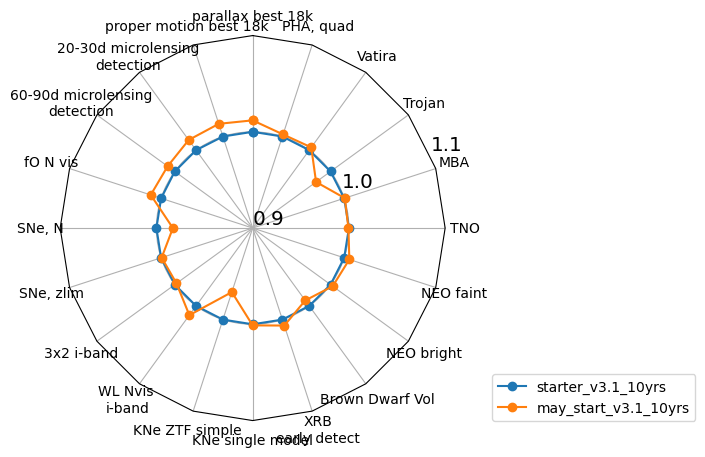

In [21]:
runs = ['starter_v3.1_10yrs', 'may_start_v3.1_10yrs' ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

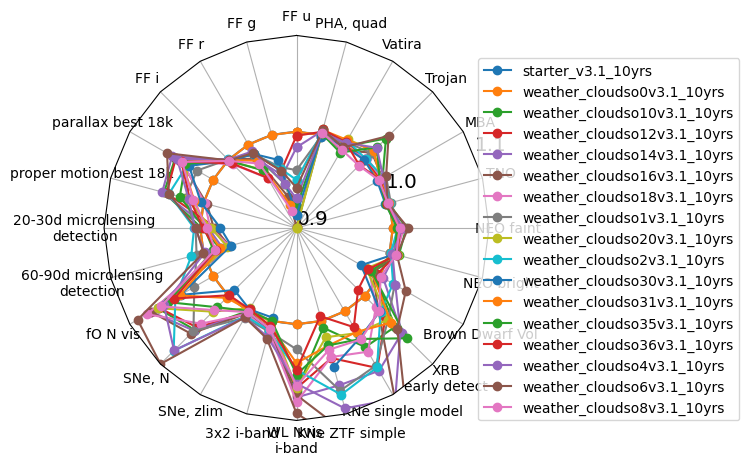

In [49]:
# What happens when we vary the weather?

# 

runs = ['starter_v3.1_10yrs']+ [run for run in data.index if 'weather' in run]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

# Generating year 1 templates

Turning up weight to make sure we have templates in year 1 for u and g filters. 

Surprising boost for SNe and parallax. Looks like having u and g weight up to 50 works well.

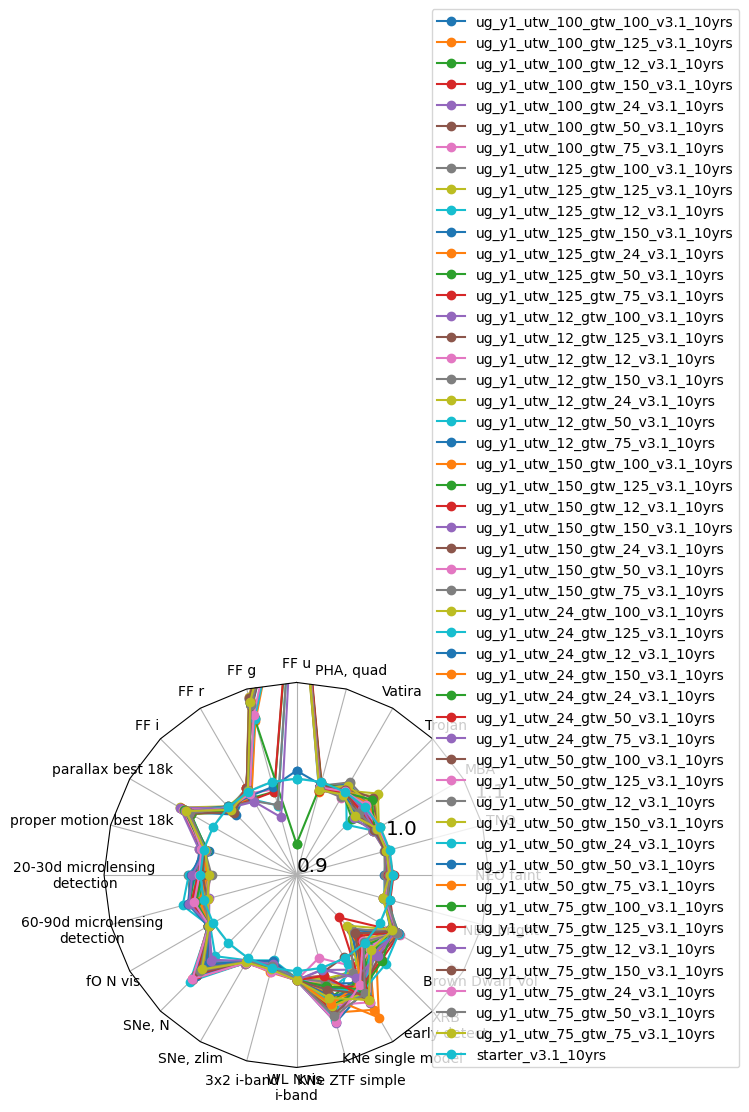

In [50]:
# 

runs = [run for run in data.index if '3.1' in run and 'weather' not in run and 'utw' in run] + ['starter_v3.1_10yrs']
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [51]:
data.loc[runs]

FF u      FF g      FF r      FF i   
ug_y1_utw_100_gtw_100_v3.1_10yrs  0.973214  0.979370  0.998271  0.993823  \
ug_y1_utw_100_gtw_125_v3.1_10yrs  0.975586  0.987894  0.998518  0.993453   
ug_y1_utw_100_gtw_12_v3.1_10yrs   0.972656  0.897838  0.987153  0.999135   
ug_y1_utw_100_gtw_150_v3.1_10yrs  0.976981  0.984558  0.998765  0.991476   
ug_y1_utw_100_gtw_24_v3.1_10yrs   0.974609  0.968623  0.989006  0.996170   
ug_y1_utw_100_gtw_50_v3.1_10yrs   0.973772  0.983323  0.996047  0.993947   
ug_y1_utw_100_gtw_75_v3.1_10yrs   0.976283  0.990241  0.998271  0.994317   
ug_y1_utw_125_gtw_100_v3.1_10yrs  0.973075  0.987029  0.998765  0.993329   
ug_y1_utw_125_gtw_125_v3.1_10yrs  0.976702  0.983323  0.997406  0.995306   
ug_y1_utw_125_gtw_12_v3.1_10yrs   0.973214  0.884373  0.985176  0.997529   
ug_y1_utw_125_gtw_150_v3.1_10yrs  0.976702  0.988758  0.998271  0.986905   
ug_y1_utw_125_gtw_24_v3.1_10yrs   0.975586  0.966646  0.988388  0.997653   
ug_y1_utw_125_gtw_50_v3.1_10yrs   0.975446  0.981347  0.995676  0.995676   
ug_y1_utw_125_gtw_75_v3.1_10yrs   0.977818  0.983447  0.996912  0.994317   
ug_y1_utw_12_gtw_100_v3.1_10yrs   0.077009  0.985794  0.997653  0.997282   
ug_y1_utw_12_gtw_125_v3.1_10yrs   0.058175  0.987647  0.998147  0.997406   
ug_y1_utw_12_gtw_12_v3.1_10yrs    0.082589  0.900062  0.992588  0.999135   
ug_y1_utw_12_gtw_150_v3.1_10yrs   0.069057  0.985547  0.997282  0.997529   
ug_y1_utw_12_gtw_24_v3.1_10yrs    0.082310  0.981594  0.996047  0.999012   
ug_y1_utw_12_gtw_50_v3.1_10yrs    0.055804  0.981099  0.996912  0.996788   
ug_y1_utw_12_gtw_75_v3.1_10yrs    0.055943  0.986411  0.997776  0.996912   
ug_y1_utw_150_gtw_100_v3.1_10yrs  0.970703  0.986041  0.998518  0.991106   
ug_y1_utw_150_gtw_125_v3.1_10yrs  0.970006  0.982952  0.997406  0.990364   
ug_y1_utw_150_gtw_12_v3.1_10yrs   0.979911  0.897962  0.985176  0.997529   
ug_y1_utw_150_gtw_150_v3.1_10yrs  0.974470  0.981470  0.998147  0.990859   
ug_y1_utw_150_gtw_24_v3.1_10yrs   0.966657  0.970970  0.992094  0.996047   
ug_y1_utw_150_gtw_50_v3.1_10yrs   0.969029  0.981964  0.995800  0.993823   
ug_y1_utw_150_gtw_75_v3.1_10yrs   0.976004  0.985547  0.997159  0.993823   
ug_y1_utw_24_gtw_100_v3.1_10yrs   0.595564  0.986411  0.998518  0.996418   
ug_y1_utw_24_gtw_125_v3.1_10yrs   0.594169  0.982335  0.998765  0.995800   
ug_y1_utw_24_gtw_12_v3.1_10yrs    0.771066  0.902656  0.989747  0.998888   
ug_y1_utw_24_gtw_150_v3.1_10yrs   0.608817  0.983941  0.998394  0.994194   
ug_y1_utw_24_gtw_24_v3.1_10yrs    0.712891  0.969487  0.994812  0.998023   
ug_y1_utw_24_gtw_50_v3.1_10yrs    0.642299  0.982088  0.995182  0.996541   
ug_y1_utw_24_gtw_75_v3.1_10yrs    0.632533  0.981470  0.995800  0.996418   
ug_y1_utw_50_gtw_100_v3.1_10yrs   0.955357  0.981099  0.998518  0.993947   
ug_y1_utw_50_gtw_125_v3.1_10yrs   0.957031  0.986535  0.998147  0.995059   
ug_y1_utw_50_gtw_12_v3.1_10yrs    0.971122  0.884867  0.983323  0.998641   
ug_y1_utw_50_gtw_150_v3.1_10yrs   0.956055  0.990488  0.998271  0.992464   
ug_y1_utw_50_gtw_24_v3.1_10yrs    0.967494  0.969240  0.992835  0.997900   
ug_y1_utw_50_gtw_50_v3.1_10yrs    0.968331  0.983941  0.995429  0.996047   
ug_y1_utw_50_gtw_75_v3.1_10yrs    0.971819  0.984188  0.998641  0.992588   
ug_y1_utw_75_gtw_100_v3.1_10yrs   0.970145  0.984682  0.995800  0.991970   
ug_y1_utw_75_gtw_125_v3.1_10yrs   0.965123  0.984064  0.998641  0.994812   
ug_y1_utw_75_gtw_12_v3.1_10yrs    0.966797  0.872884  0.982705  0.996788   
ug_y1_utw_75_gtw_150_v3.1_10yrs   0.971540  0.989129  0.998518  0.989870   
ug_y1_utw_75_gtw_24_v3.1_10yrs    0.974051  0.972699  0.991970  0.996788   
ug_y1_utw_75_gtw_50_v3.1_10yrs    0.970424  0.982211  0.996541  0.996294   
ug_y1_utw_75_gtw_75_v3.1_10yrs    0.971261  0.985547  0.995800  0.993947   
starter_v3.1_10yrs                0.764648  0.907350  0.994688  0.998271   

                                  parallax best 18k  proper motion best 18k   
ug_y1_utw_100_gtw_100_v3.1_10yrs           0.782865                0.187913  \
ug_

# DDF split in night



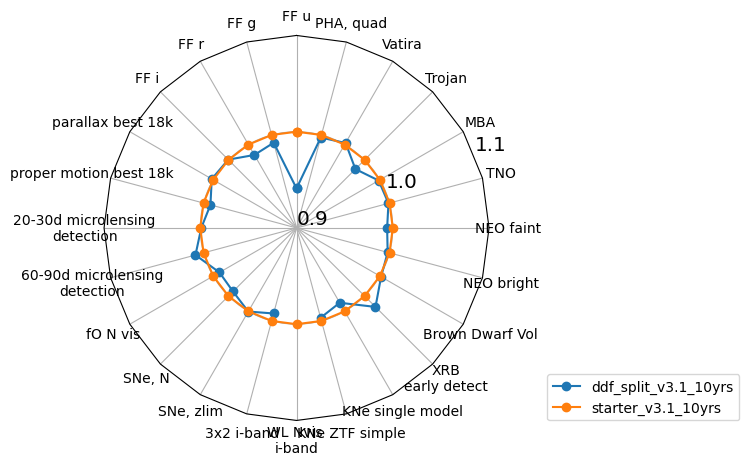

In [58]:
# 

runs = [run for run in data.index if 'split' in run] + ['starter_v3.1_10yrs']
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [59]:
# That's an odd NaN. Probably just a job failed on hyak or something.
data.loc[runs]["WL Nvis \ni-band"]

ddf_split_v3.1_10yrs      NaN
starter_v3.1_10yrs      421.0
Name: WL Nvis \ni-band, dtype: float64

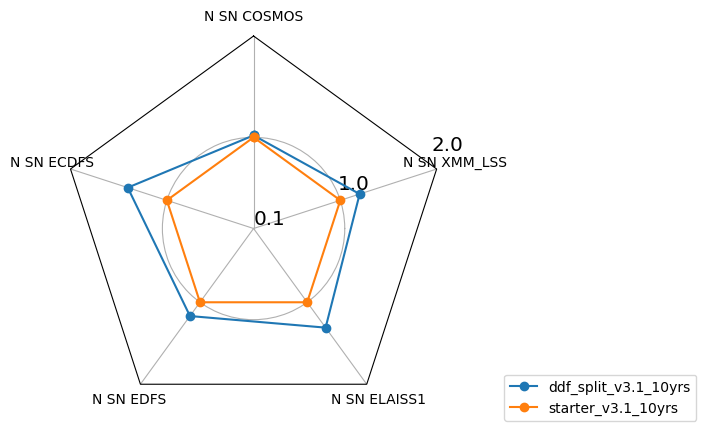

In [62]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 2], bbox_to_anchor=(1.65, 0))

In [63]:
ddf_data.loc[runs]

N SN COSMOS  N SN ECDFS   N SN EDFS  N SN ELAISS1   
ddf_split_v3.1_10yrs   580.936525  455.187854  803.466338    393.295885  \
starter_v3.1_10yrs     570.092693  323.804586  687.881760    300.350011   

                      N SN XMM_LSS  zlim COSMOS  zlim ECDFS  zlim EDFS   
ddf_split_v3.1_10yrs    374.911756     0.545961    0.578368   0.514147  \
starter_v3.1_10yrs      312.194755     0.571789    0.582438   0.525004   

                      zlim ELAISS1  zlim XMM_LSS  
ddf_split_v3.1_10yrs      0.557940      0.543341  
starter_v3.1_10yrs        0.573883      0.565746

# Compare 3.1 and 3.0 median coadded depths.
# Changes of order 0.01 mags, so not really any change at all.

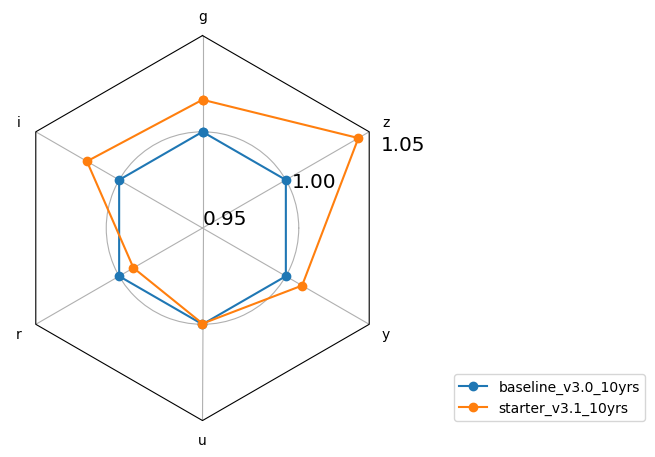

In [24]:
runs = ['baseline_v3.0_10yrs', 'starter_v3.1_10yrs']
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [25]:
mag_data.loc[runs]

g          i          r          u          y   
baseline_v3.0_10yrs  26.688123  26.264600  26.818287  25.668262  24.756955  \
starter_v3.1_10yrs   26.704783  26.283927  26.809699  25.667902  24.766694   

                             z  
baseline_v3.0_10yrs  25.524781  
starter_v3.1_10yrs   25.568286

# Compare number of SNe in the DDFs
# Huge boost in all the DDFs.

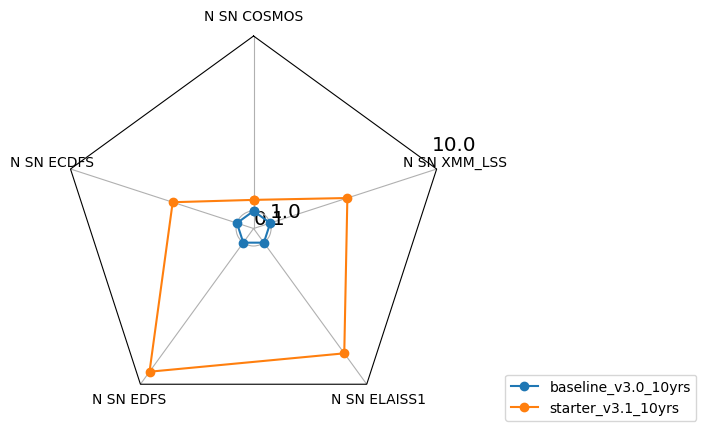

In [26]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 10], bbox_to_anchor=(1.65, 0))

# SNe redshift limits in the DDFs. No big changes

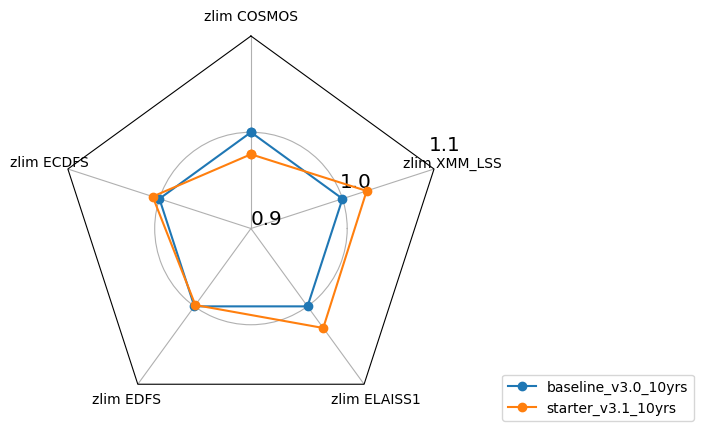

In [27]:
cols = [col for col in ddf_data.columns.values.tolist() if 'zlim' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='baseline_v3.0_10yrs', mag_cols='all')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [28]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs', 'starter_v3.1_10yrs']

In [29]:
sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_data

parallax best 18k  proper motion best 18k   
retro_baseline_v2.0_10yrs           0.804328                0.176701  \
baseline_v2.0_10yrs                 0.791058                0.184088   
baseline_v2.1_10yrs                 0.806910                0.188258   
baseline_v2.2_10yrs                 0.792958                0.186345   
baseline_v3.0_10yrs                 0.792666                0.185683   
starter_v3.1_10yrs                  0.806804                0.187549   

                           20-30d microlensing\ndetection   
retro_baseline_v2.0_10yrs                          0.0883  \
baseline_v2.0_10yrs                                0.3116   
baseline_v2.1_10yrs                                0.3111   
baseline_v2.2_10yrs                                0.3212   
baseline_v3.0_10yrs                                0.3239   
starter_v3.1_10yrs                                 0.3315   

                           60-90d microlensing\ndetection  fO N vis   
retro_baseline_v2.0_10yrs                          0.1533     848.0  \
baseline_v2.0_10yrs                                0.4284     839.0   
baseline_v2.1_10yrs                                0.4312     838.0   
baseline_v2.2_10yrs                                0.4462     830.0   
baseline_v3.0_10yrs                                0.4559     795.0   
starter_v3.1_10yrs                                 0.4585     794.0   

                                  SNe, N  SNe, zlim  3x2 i-band   
retro_baseline_v2.0_10yrs   97124.012102   0.281304   34.632263  \
baseline_v2.0_10yrs         99302.532220   0.282012   37.908126   
baseline_v2.1_10yrs         99294.339899   0.283756   38.560143   
baseline_v2.2_10yrs        112802.099640   0.289980   39.794283   
baseline_v3.0_10yrs        109475.798536   0.293926   38.643260   
starter_v3.1_10yrs         120595.577833   0.302535   39.394057   

                           WL Nvis \ni-band  KNe ZTF simple  KNe single model   
retro_baseline_v2.0_10yrs             449.0          2763.0            3982.0  \
baseline_v2.0_10yrs                   443.0          3433.0            4544.0   
baseline_v2.1_10yrs                   443.0          3585.0            4777.0   
baseline_v2.2_10yrs                   440.0          3950.0            5215.0   
baseline_v3.0_10yrs                   423.0          4308.0            5654.0   
starter_v3.1_10yrs                    421.0          3529.0            5366.0   

                           XRB\nearly detect  Brown Dwarf Vol  NEO bright   
retro_baseline_v2.0_10yrs              720.0    179640.718155      0.9048  \
baseline_v2.0_10yrs                   1879.0    168086.074111      0.9294   
baseline_v2.1_10yrs                   1918.0    163815.013503      0.9286   
baseline_v2.2_10yrs                   1920.0    172453.127988      0.9304   
baseline_v3.0_10yrs                   1950.0    168032.537231      0.9326   
starter_v3.1_10yrs                    1997.0    172220.399208      0.9300   

                           NEO faint       TNO       MBA    Trojan  Vatira   
retro_baseline_v2.0_10yrs   0.623933  0.705953  0.943433  0.667158     NaN  \
baseline_v2.0_10yrs         0.642021  0.719635  0.918999  0.588087  0.0039   
baseline_v2.1_10yrs         0.647553  0.723197  0.927567  0.608979  0.0017   
baseline_v2.2_10yrs         0.657462  0.723899  0.933507  0.615249  0.0008   
baseline_v3.0_10yrs         0.642155  0.722293  0.924156  0.611053  0.0376   
starter_v3.1_10yrs          0.640541  0.722337  0.930381  0.607340  0.0464   

                           PHA, quad  
retro_baseline_v2.0_10yrs   0.847880  
baseline_v2.0_10yrs         0.859238  
baseline_v2.1_10yrs         0.865438  
baseline_v2.2_10yrs         0.858538  
baseline_v3.0_10yrs         0.887938  
starter_v3.1_10yrs          0.877435

# Major science metrics changes over simulation version

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_89152/2626072435.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


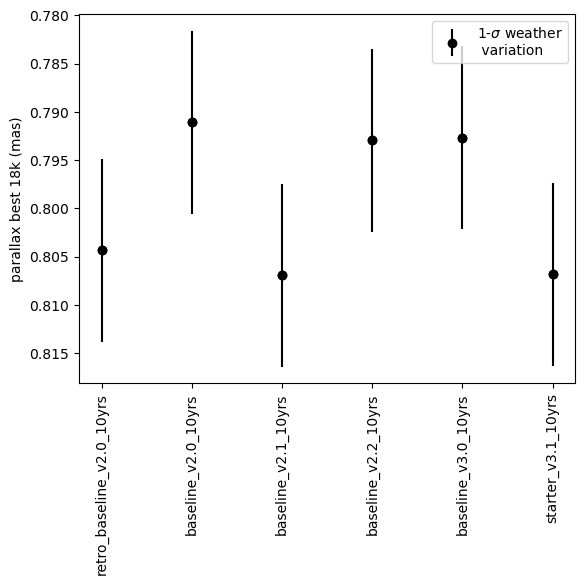

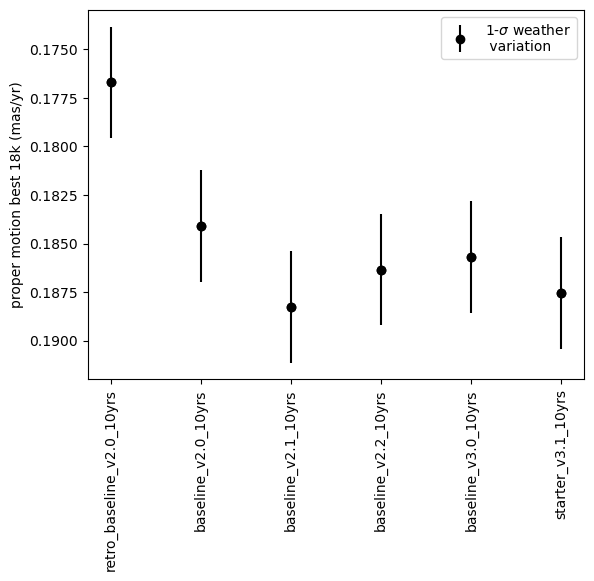

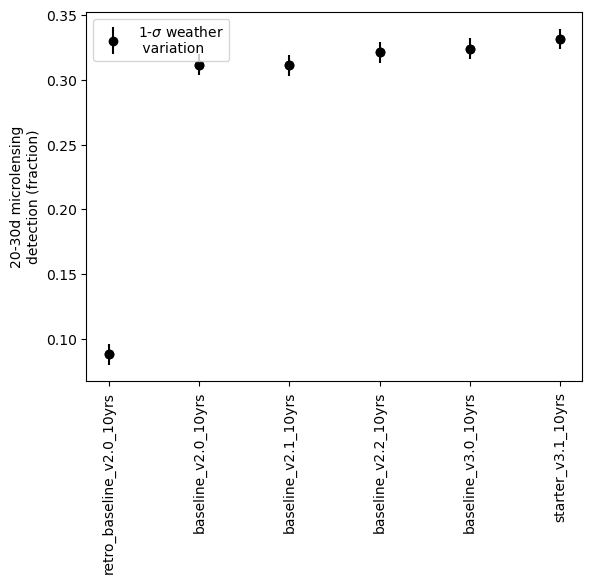

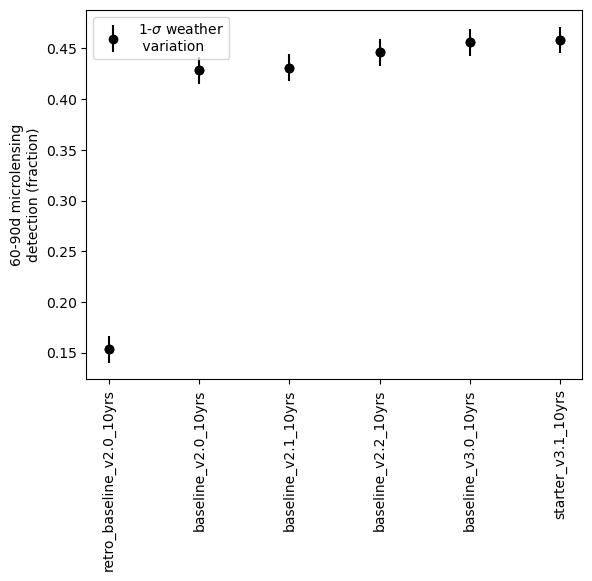

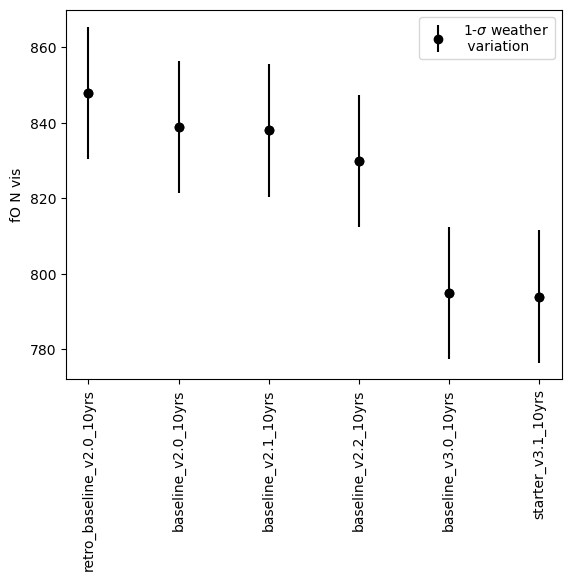

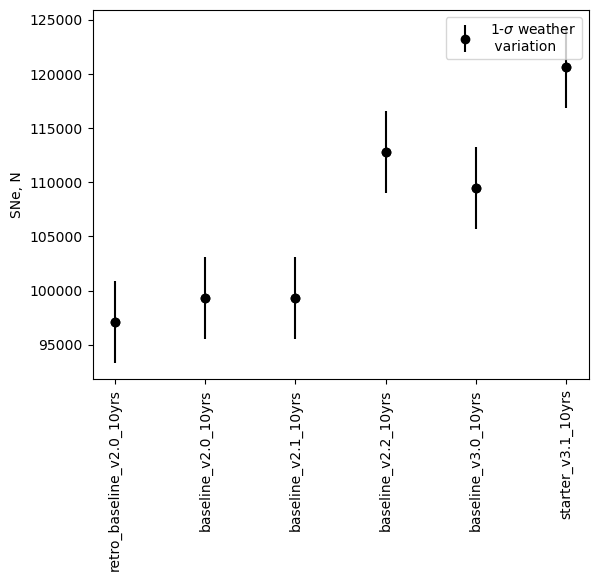

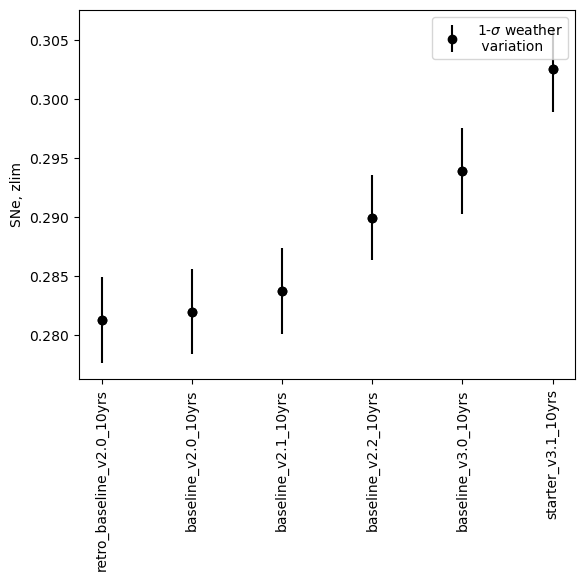

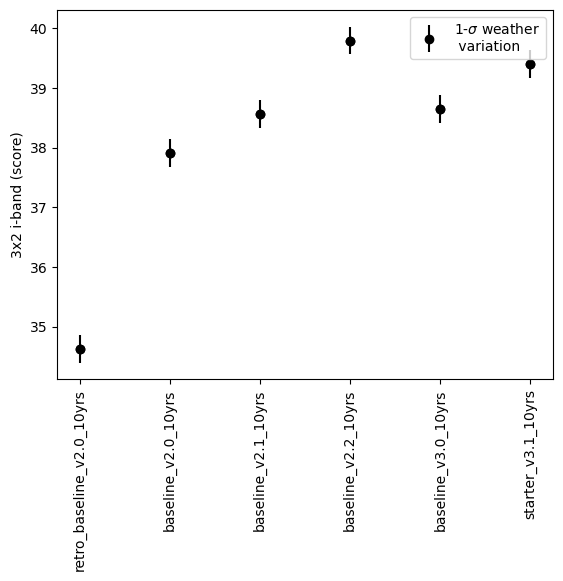

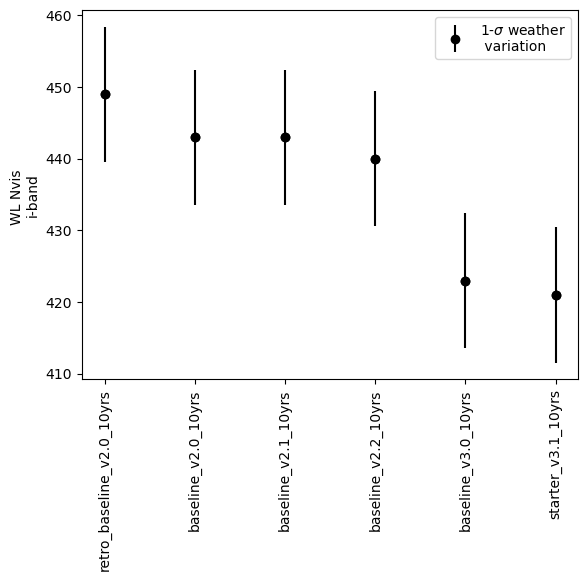

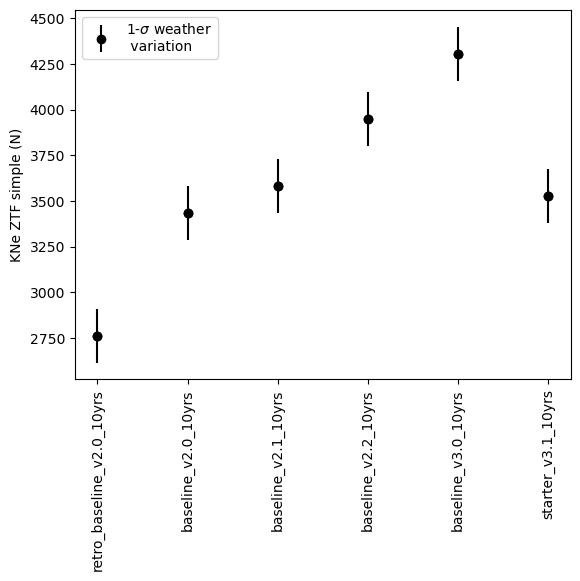

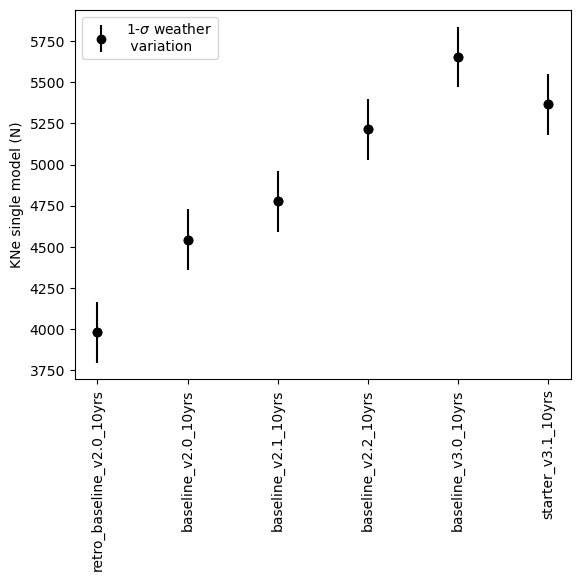

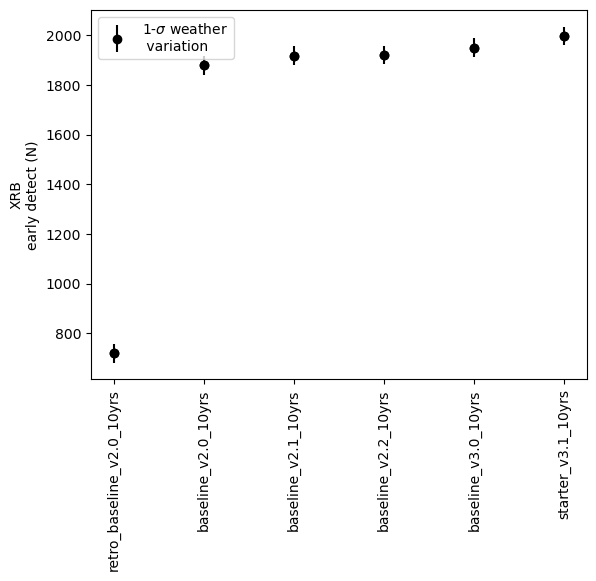

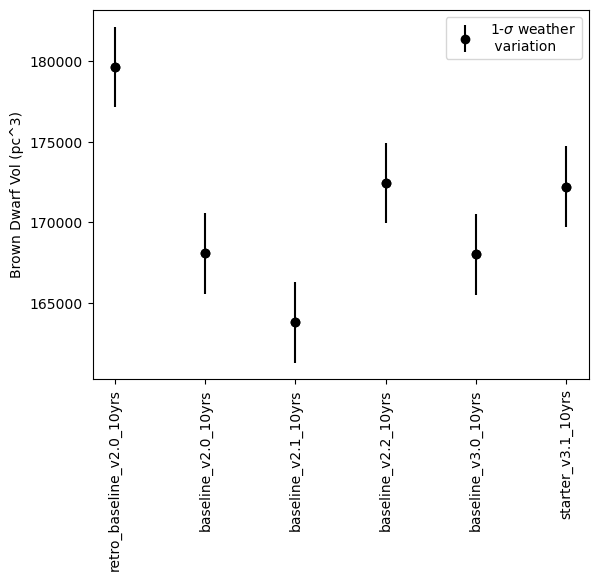

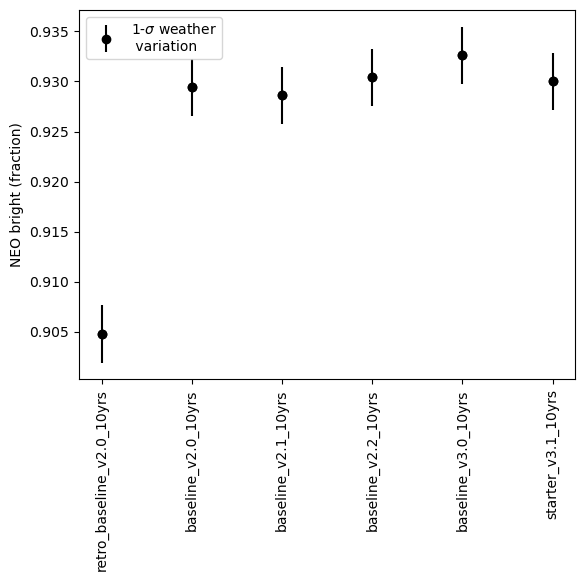

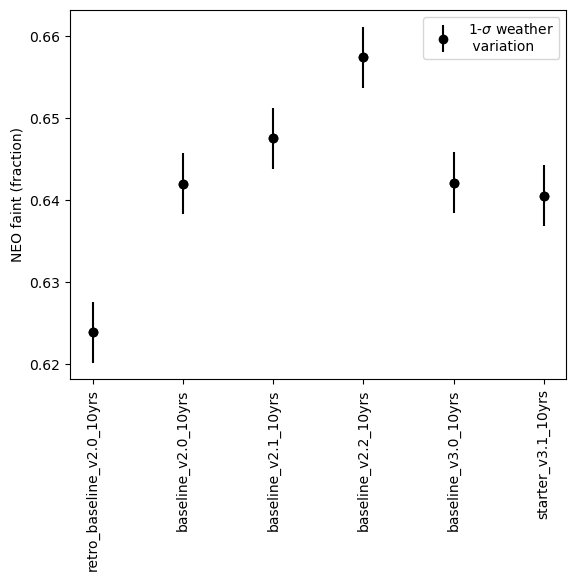

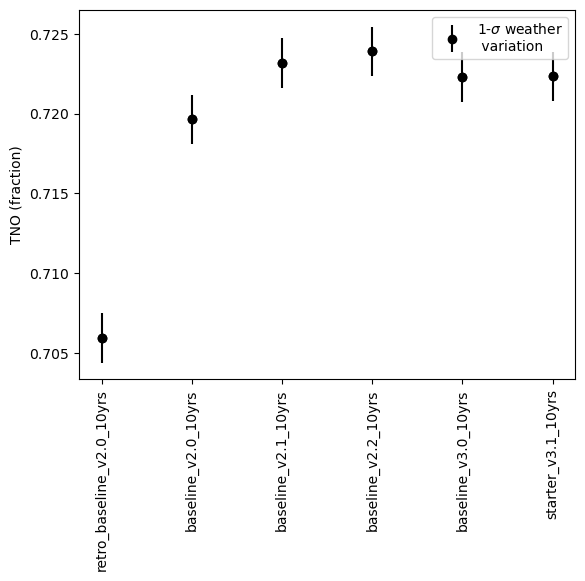

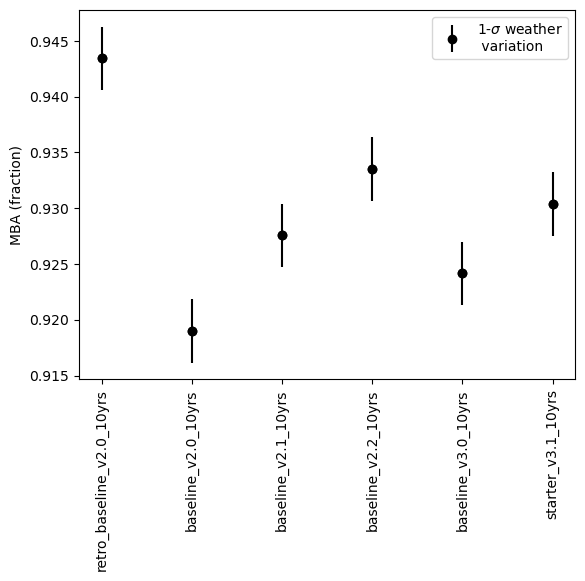

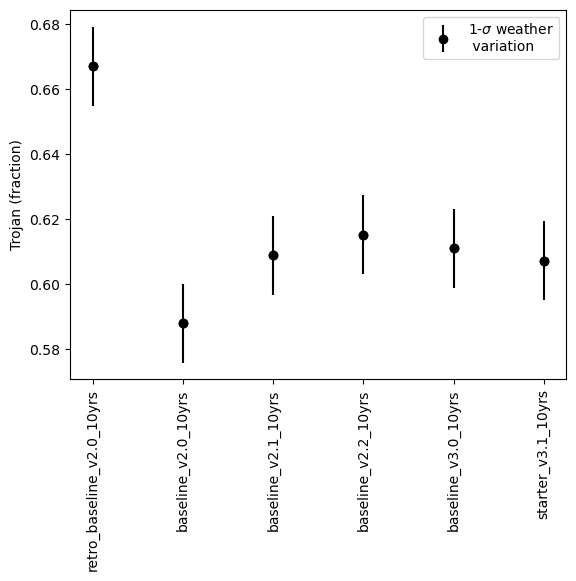

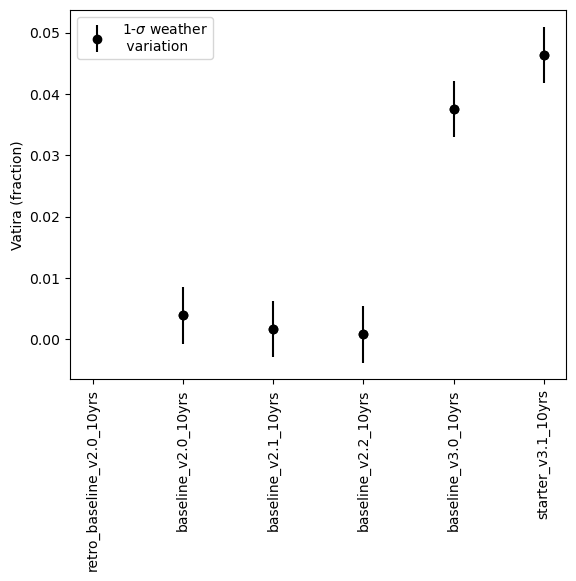

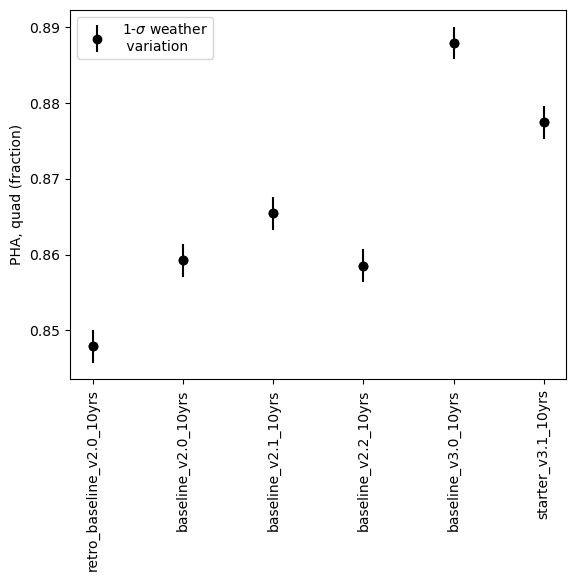

In [30]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_89152/1579871323.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_ddf[col].values.size), sub_ddf[col], yerr=std_ddf_dict[col], fmt='s', color='k',


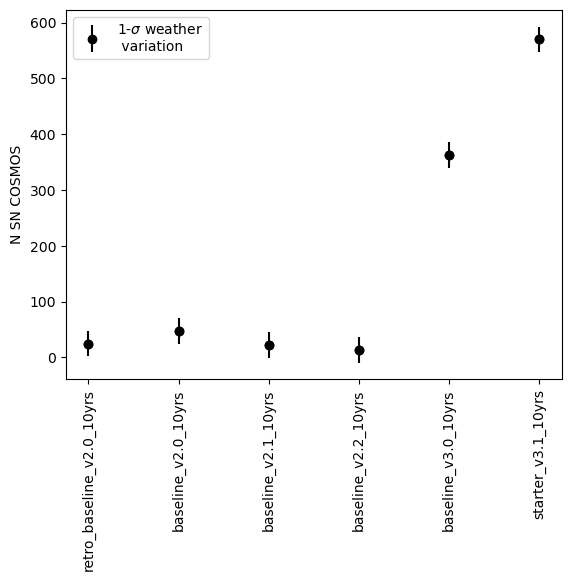

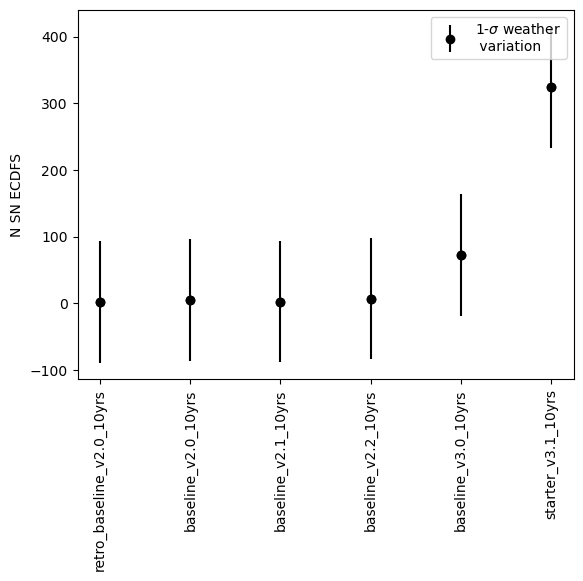

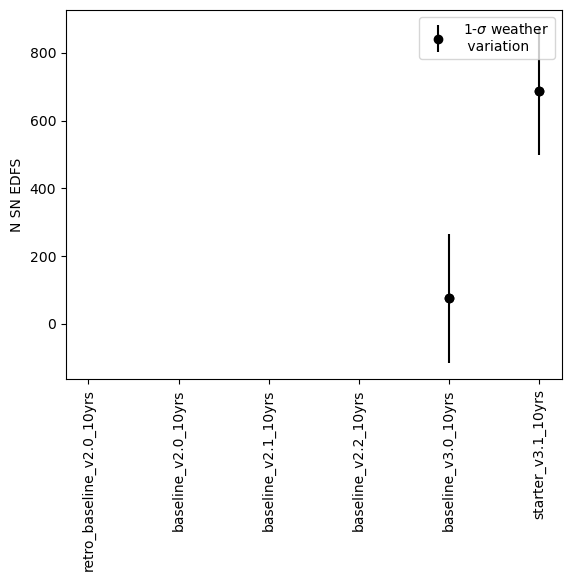

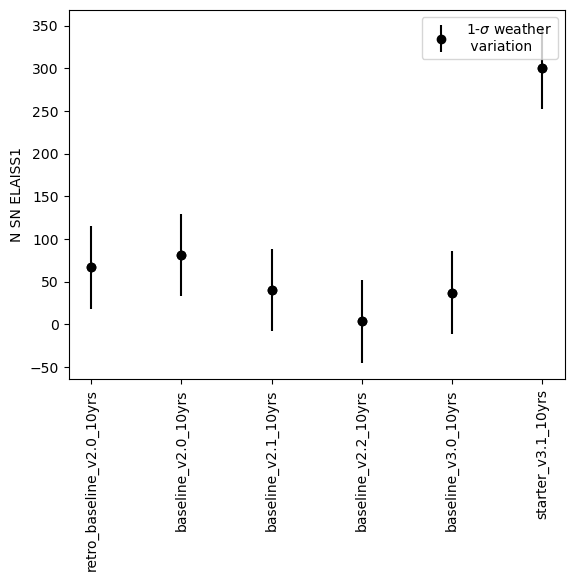

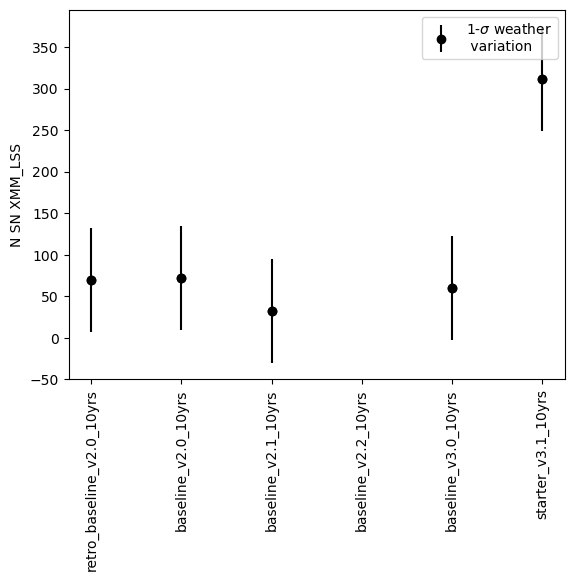

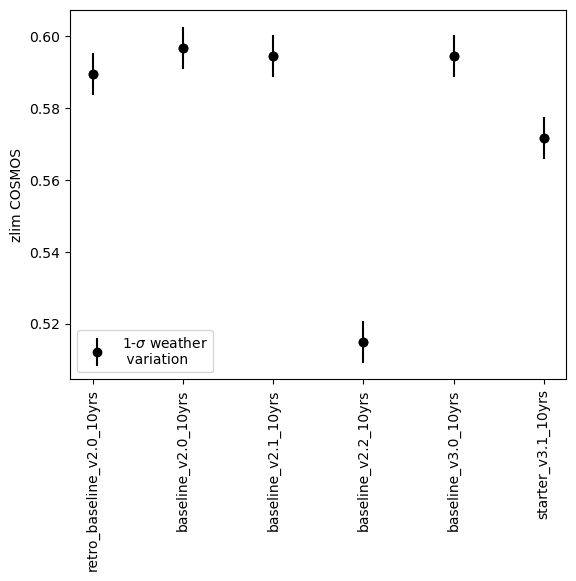

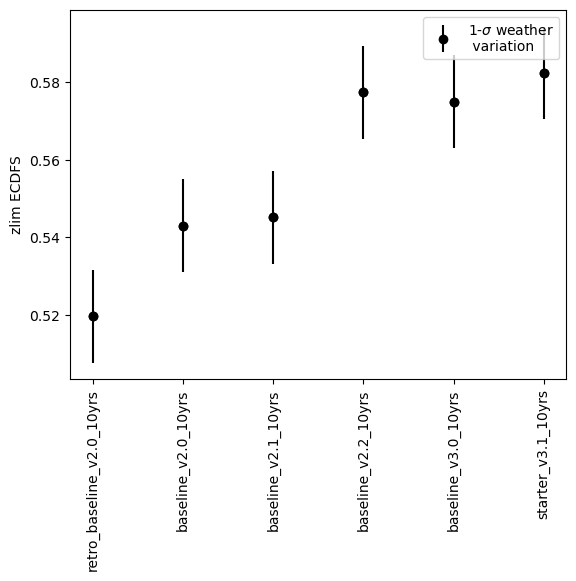

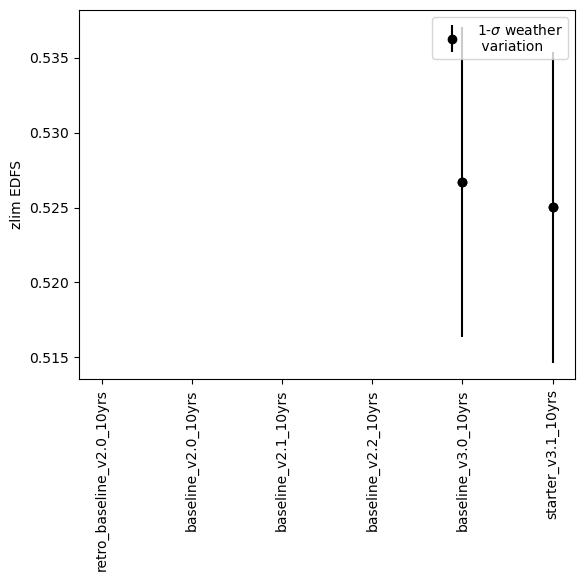

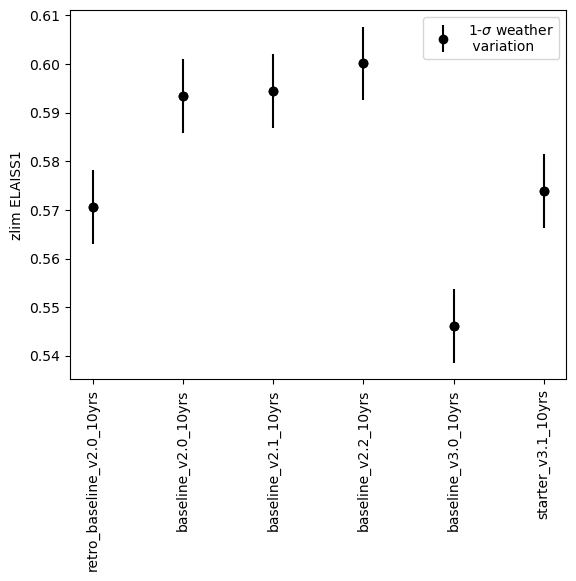

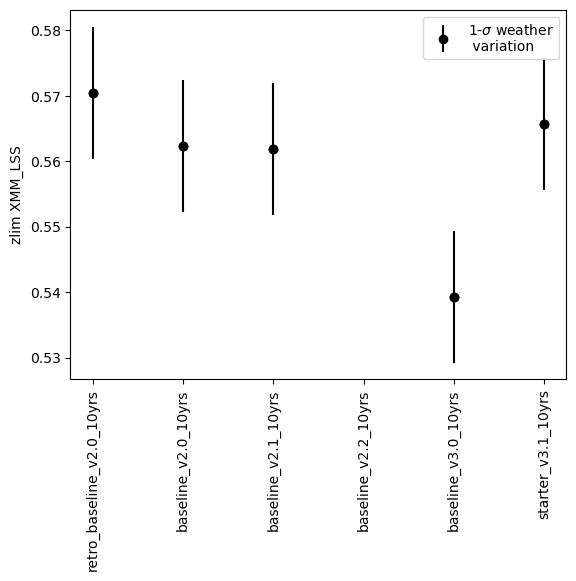

In [31]:
for col in sub_ddf.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_ddf[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_ddf[col].values.size), sub_ddf[col], yerr=std_ddf_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_89152/1447107222.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',


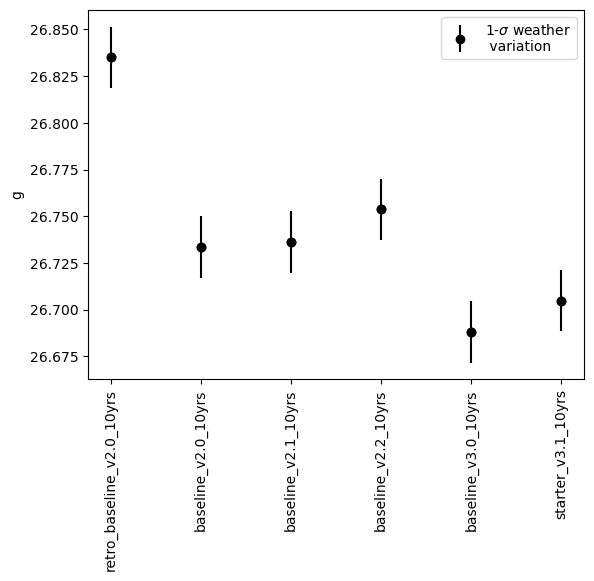

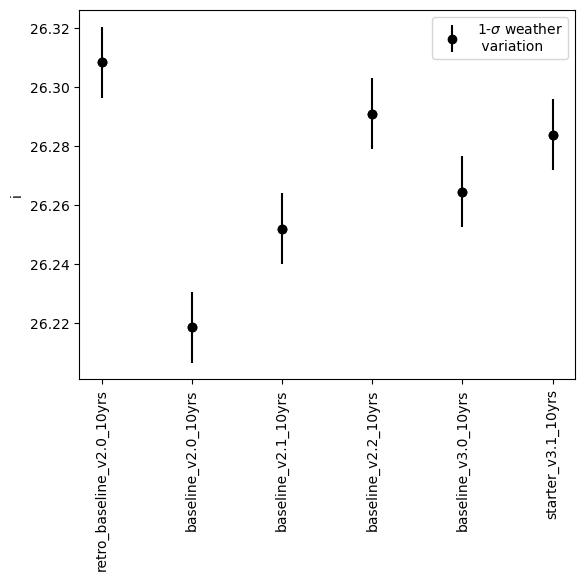

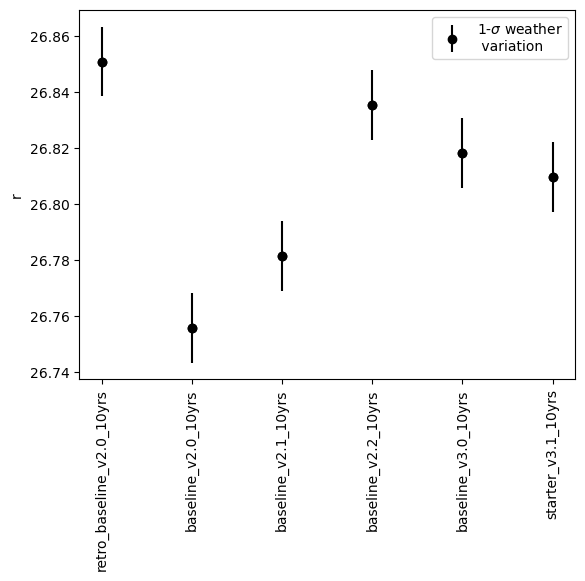

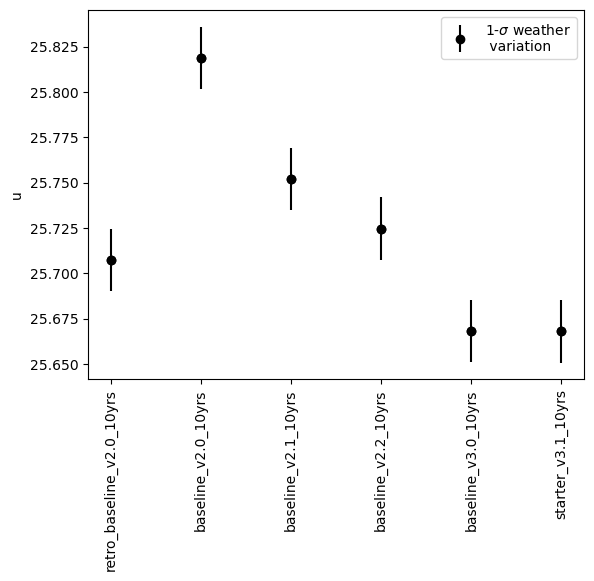

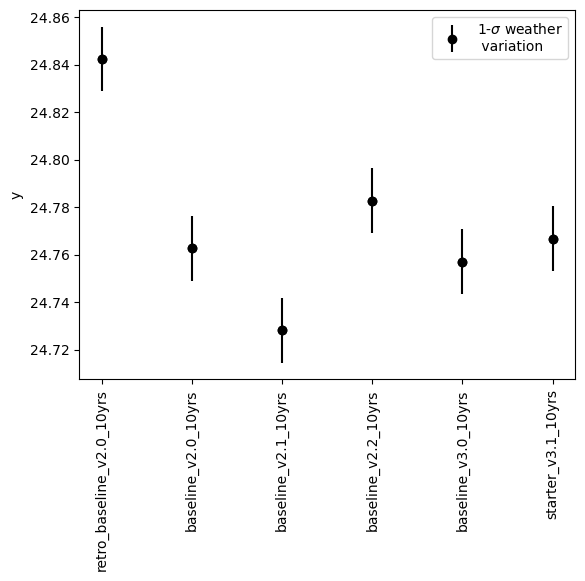

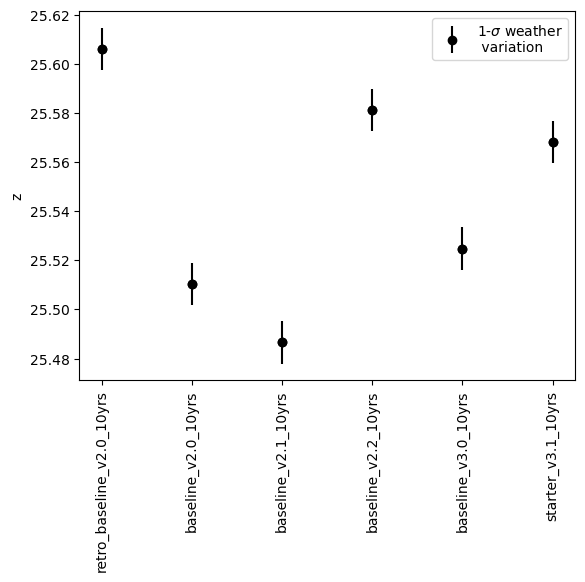

In [32]:
for col in sub_mag.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_mag[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_mag[col].values.size), sub_mag[col], yerr=std_mag_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])

# DDF performance over simulation version

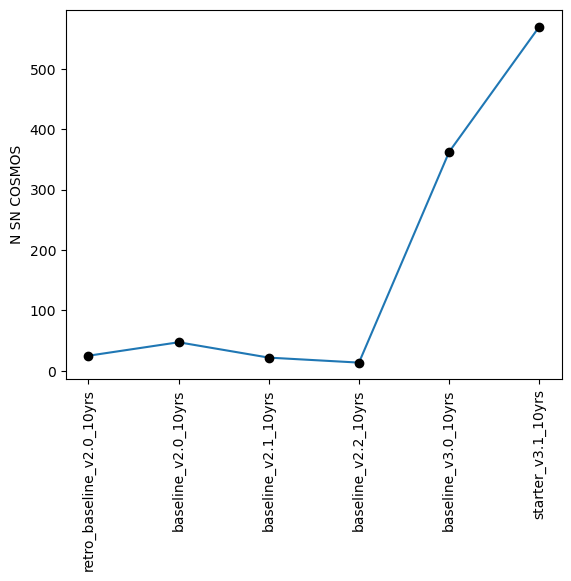

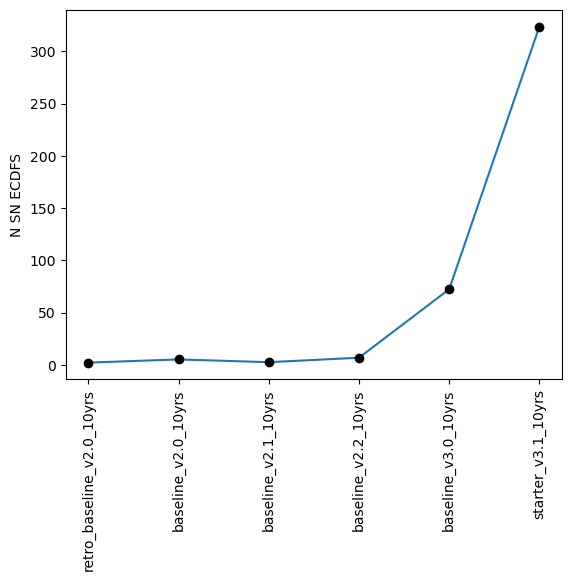

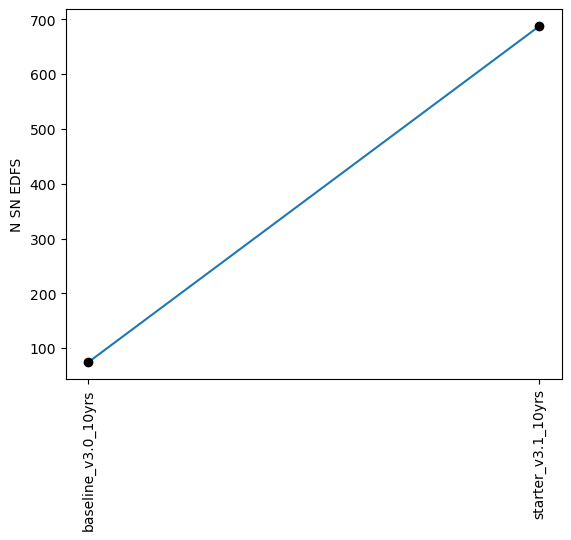

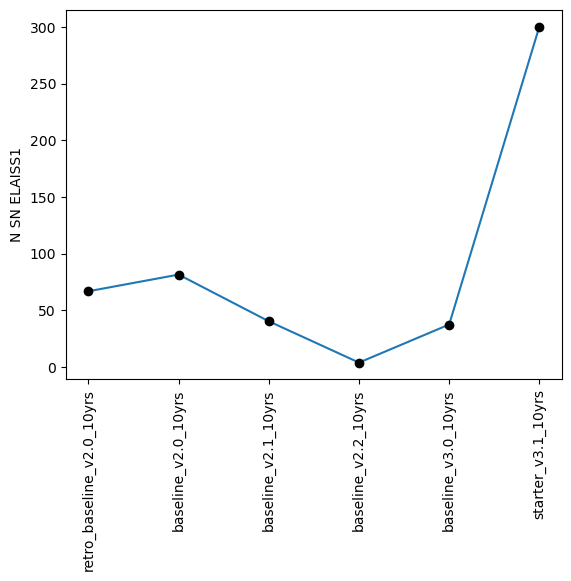

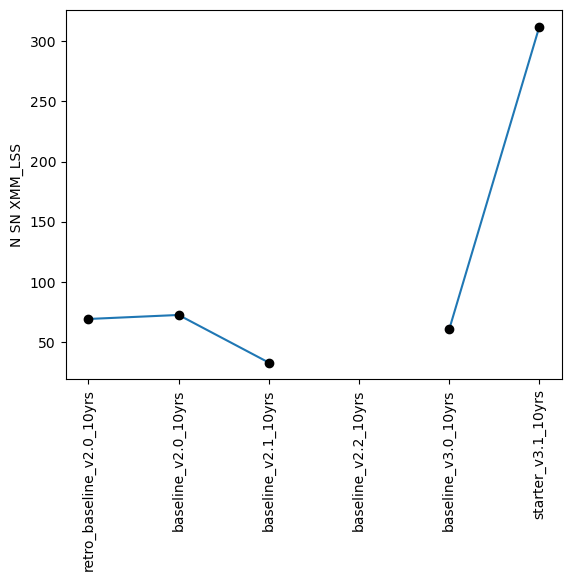

In [33]:

for col in sub_ddf.columns[0:5]:
    fig, ax = plt.subplots()
    ax.plot(sub_ddf[col])
    ax.plot(sub_ddf[col], 'ko')
    ax.set_ylabel(col)
    ax.tick_params(axis='x', labelrotation = 90)

In [34]:
# check that we have the depths and weighted seeing per year
cols = [col for col in data_loaded.columns if 'coadd g' in col and 'Median' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median coadd g, year<1 night<365 and g HealpixSlicer      25.448086
Median coadd g, year<10 night<3652 and g HealpixSlicer    26.704431
Median coadd g, year<2 night<730 and g HealpixSlicer      25.812105
Median coadd g, year<3 night<1095 and g HealpixSlicer     26.090762
Median coadd g, year<4 night<1461 and g HealpixSlicer     26.272773
Median coadd g, year<5 night<1826 and g HealpixSlicer     26.366324
Median coadd g, year<6 night<2191 and g HealpixSlicer     26.461005
Median coadd g, year<7 night<2556 and g HealpixSlicer     26.538204
Median coadd g, year<8 night<2922 and g HealpixSlicer     26.590252
Median coadd g, year<9 night<3287 and g HealpixSlicer     26.640749
Name: starter_v3.1_10yrs, dtype: float64

In [35]:
cols = [col for col in data_loaded.columns if 'Median SNR-weighted FWHMeff g' in col]
data_loaded.loc['starter_v3.1_10yrs'][cols]

Median SNR-weighted FWHMeff g, year<1 night<365 and g HealpixSlicer      0.921794
Median SNR-weighted FWHMeff g, year<10 night<3652 and g HealpixSlicer    1.071704
Median SNR-weighted FWHMeff g, year<2 night<730 and g HealpixSlicer      0.960151
Median SNR-weighted FWHMeff g, year<3 night<1095 and g HealpixSlicer     0.964676
Median SNR-weighted FWHMeff g, year<4 night<1461 and g HealpixSlicer     0.966860
Median SNR-weighted FWHMeff g, year<5 night<1826 and g HealpixSlicer     0.989195
Median SNR-weighted FWHMeff g, year<6 night<2191 and g HealpixSlicer     1.011970
Median SNR-weighted FWHMeff g, year<7 night<2556 and g HealpixSlicer     1.034818
Median SNR-weighted FWHMeff g, year<8 night<2922 and g HealpixSlicer     1.063029
Median SNR-weighted FWHMeff g, year<9 night<3287 and g HealpixSlicer     1.071067
Name: starter_v3.1_10yrs, dtype: float64

In [36]:
std_dict

{'parallax best 18k': 0.009478899156682105,
 'proper motion best 18k': 0.0028672429122951933,
 '20-30d microlensing\ndetection': 0.00798120595132716,
 '60-90d microlensing\ndetection': 0.01306602823163949,
 'fO N vis': 17.5088147442938,
 'SNe, N': 3771.934278275806,
 'SNe, zlim': 0.003606171733302274,
 '3x2 i-band': 0.2333686741233221,
 'WL Nvis \ni-band': 9.440809758113383,
 'KNe ZTF simple': 147.61753791470713,
 'KNe single model': 184.1841809168203,
 'XRB\nearly detect': 37.750620855821694,
 'Brown Dwarf Vol': 2499.3849477701256,
 'NEO bright': 0.002879995659718928,
 'NEO faint': 0.0037125784021960033,
 'TNO': 0.001559716556565792,
 'MBA': 0.0028393416107814536,
 'Trojan': 0.01213598194295356,
 'Vatira': 0.0046096366451164016,
 'PHA, quad': 0.002136601960780383}